# The existence of dimensions within the halbach array expressed as a single or multiple components

Author: *Gyavira Ayebare.B*

## introduction

A [Halbach array](https://en.wikipedia.org/wiki/Halbach_array) is a specific arrangement of magnets that directs the [magnetic field](https://en.wikipedia.org/wiki/Magnetic_field) predominantly to one side while nearly canceling it on the opposite side. This conventional interpretation limits our understanding by focusing on the sides of the array rather than the structure encompassing the field itself.

When utilizing a cubic-shaped magnet, the current definition suggests an underutilization of the array's sides, as attention is primarily given to only 2 of the 6 sides. 

By leveraging all the sides, various substructures and superstructures can be constructed, facilitating the creation of complex [surfaces](https://en.wikipedia.org/wiki/Surface) and [dimensions](https://en.wikipedia.org/wiki/Dimension).

## Simulation setup

The [FEMM](https://www.femm.info/wiki/HomePage) (Finite Element Method Magnetics) simulation software was employed to generate 2D illustrated surfaces, demonstrating various array configurations and their resulting flux density distributions. The foundational setup was based on the [standard tutorial configuration](https://www.femm.info/wiki/PermanentMagnetExample), with minor modifications including an adjusted depth of 5 millimeters and magnet dimensions set to 5 by 5 millimeters.

### Illustrations


|  |  |  |
| --------------- | --------------- | --------------- |
| ![Pole diagram](./imgs/h_dim_1_pole_img.png) | ![Direction diagram](./imgs/h_dim_1_direction_img.png) | ![Field diagram](./imgs/h_dim_1_field_img.png) |
| ![Pole diagram](./imgs/h_dim_other_1_pole_img.PNG) | ![Direction diagram](./imgs/h_dim_other_1_direction_img.PNG) | ![Field diagram](./imgs/h_dim_other_1_field_img.PNG) |
| ![Pole diagram](./imgs/h_dim_other_2_pole_img.PNG) | ![Direction diagram](./imgs/h_dim_other_2_direction_img.PNG) | ![Field diagram](./imgs/h_dim_other_2_field_img.PNG) |
| ![Pole diagram](./imgs/h_dim_other_3_pole_img.PNG) | ![Direction diagram](./imgs/h_dim_other_3_direction_img.PNG) | ![Field diagram](./imgs/h_dim_other_3_field_img.PNG) |
| ![Pole diagram](./imgs/h_dim_other_4_pole_img.PNG) | ![Direction diagram](./imgs/h_dim_other_4_direction_img.PNG) | ![Field diagram](./imgs/h_dim_other_4_field_img.PNG) |
| ![Pole diagram](./imgs/h_dim_2D_groups_1_pole_img.PNG) | ![Direction diagram](./imgs/h_dim_2D_groups_1_direction_img.PNG) | ![Field diagram](./imgs/h_dim_2D_groups_1_field_img.PNG) |
| ![Pole diagram](./imgs/h_dim_2D_groups_2_pole_img.PNG) | ![Direction diagram](./imgs/h_dim_2D_groups_2_direction_img.PNG) | ![Field diagram](./imgs/h_dim_2D_groups_2_field_img.PNG) |



## Code

In attempt to determine the configuration with the greatest magnetic field and to demonstrate how a higher dimensional structure would look like, the code below was scripted. 

Restrained to a 3D structure for easier visualisation, it utilises reinforcement learning straating with the typical halbach array setup and goes through the entire structure with the aim of extracting the target configuration.


### Imports

In [1]:
from stable_baselines3 import PPO

In [2]:
import gym
import numpy as np
from gym import Env
import matplotlib.pyplot as plt
from gym.spaces import Discrete, Box
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# take out the warnings
import warnings
warnings.filterwarnings('ignore')

### Class definition and visualisation method scripting


In [3]:
class VariableHalbachArrayEnv(Env):
    def __init__(self, dimensions, max_steps=100, maximize=True):
        super(VariableHalbachArrayEnv, self).__init__()
        self.dimensions = dimensions
        self.max_steps = max_steps
        self.current_step = 0
        self.maximize = maximize
        
        # Calculate the total number of magnets
        num_magnets = np.prod(dimensions)
        
        # Each magnet can be oriented in 4 possible directions
        self.action_space = Discrete(num_magnets * 4)
        
        # Observation space with values between 0 and 3 (inclusive)
        self.observation_space = Box(low=0, high=3, shape=dimensions, dtype=np.int32)
        
        self.halbach_array = self.initialize_halbach_array()

    def initialize_halbach_array(self):
        # Initialize a basic Halbach array pattern
        pattern = np.array([0, 1, 2, 3])  # N, S, E, W
        halbach_array = np.empty(self.dimensions, dtype=np.int32)
        
        for idx in np.ndindex(self.dimensions):
            halbach_array[idx] = pattern[sum(idx) % 4]
        
        return halbach_array

    def step(self, action):
        self.current_step += 1
        
        # Apply the action
        self.halbach_array = self.rearrange_magnets(action)
        
        # Calculate the magnetic field strength
        magnetic_field_strength = self.calculate_magnetic_field_strength()
        
        # Define the reward (maximize for strongest, minimize for weakest)
        reward = float(magnetic_field_strength if self.maximize else -magnetic_field_strength)
        
        # Check if the episode is done
        done = self.current_step >= self.max_steps
        
        # Provide the next state
        next_state = self.halbach_array.copy()
        
        return next_state, reward, done, {}

    def rearrange_magnets(self, action):
        new_halbach_array = self.halbach_array.copy()
        
        # Map the action to indices and orientation changes
        idx = action // 4
        new_orientation = action % 4
        
        # Find the coordinates of the magnet to change
        coords = np.unravel_index(idx, self.dimensions)
        new_halbach_array[coords] = new_orientation
        
        return new_halbach_array

    def calculate_magnetic_field_strength(self):
        magnetic_field_strength = 0
        for idx in np.ndindex(self.dimensions):
            contribution = self.calculate_magnet_contribution(idx)
            magnetic_field_strength += np.linalg.norm(contribution)
        return magnetic_field_strength

    def calculate_magnet_contribution(self, idx):
        magnet_field_strength = 1.0
        magnet_orientation = self.halbach_array[idx]
        
        # Define the field direction for each orientation
        directions = {
            0: np.array([1, 0, 0]),  # N
            1: np.array([-1, 0, 0]), # S
            2: np.array([0, 1, 0]),  # E
            3: np.array([0, -1, 0])  # W
        }
        
        field_direction = directions[magnet_orientation]
        
        distance = np.sqrt(sum(i**2 for i in idx))
        attenuation = 1 / (distance ** 2) if distance != 0 else 1e-6
        
        contribution = magnet_field_strength * field_direction * attenuation
        return contribution

    def reset(self):
        self.halbach_array = self.initialize_halbach_array()
        self.current_step = 0
        return self.halbach_array

def visualize_halbach_array(halbach_array):
    fig = plt.figure(figsize=(14, 14))
    ax = fig.add_subplot(111, projection='3d')
    
    # Define the colors for North and South poles
    colors = ['red', 'blue', 'green', 'yellow']  # N, S, E, W
    
    def plot_cube_at(pos, ax, colors):
        """ 
        Plot a cube element at position `pos` with face colors.
        """
        r = [-0.5, 0.5]
        vertices = np.array([[x, y, z] for x in r for y in r for z in r])
        faces = [
            [vertices[j] for j in [0, 1, 3, 2]], [vertices[j] for j in [4, 5, 7, 6]], 
            [vertices[j] for j in [0, 1, 5, 4]], [vertices[j] for j in [2, 3, 7, 6]], 
            [vertices[j] for j in [0, 2, 6, 4]], [vertices[j] for j in [1, 3, 7, 5]]
        ]
        faces = np.array(faces) + pos
        face_colors = colors * len(faces)
        ax.add_collection3d(Poly3DCollection(faces, facecolors=face_colors, linewidths=1, edgecolors='black', alpha=.75))

    for idx in np.ndindex(halbach_array.shape):
        orientation = halbach_array[idx]
        color = colors[orientation]
        cube_colors = [color] * 6  # Apply the same color to all faces
        plot_cube_at(idx, ax, cube_colors)
    
    ax.set_xlim([-0.5, halbach_array.shape[0]-0.5])
    ax.set_ylim([-0.5, halbach_array.shape[1]-0.5])
    ax.set_zlim([-0.5, halbach_array.shape[2]-0.5])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Halbach Array Visualization with Cubes')
    
    plt.show()



### Object creation

In [4]:
# Training the agent for strongest configuration
env_strong = VariableHalbachArrayEnv((8, 8, 3), maximize=True)
agent_strong = PPO('MlpPolicy', env_strong, verbose=1)
total_timesteps = 150000
agent_strong.learn(total_timesteps=total_timesteps)

# Evaluate the trained agent for strongest configuration
obs = env_strong.reset()
origin = obs
done = False
while not done:
    action, _ = agent_strong.predict(obs)
    obs, reward, done, _ = env_strong.step(action)
print(f"Final magnetic field strength (strongest): {reward:.2f}")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | 1.36e+03 |
| time/              |          |
|    fps             | 394      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | 1.36e+03     |
| time/                   |              |
|    fps                  | 348          |
|    iterations           | 2            |
|    time_elapsed         | 11           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0016856687 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    en

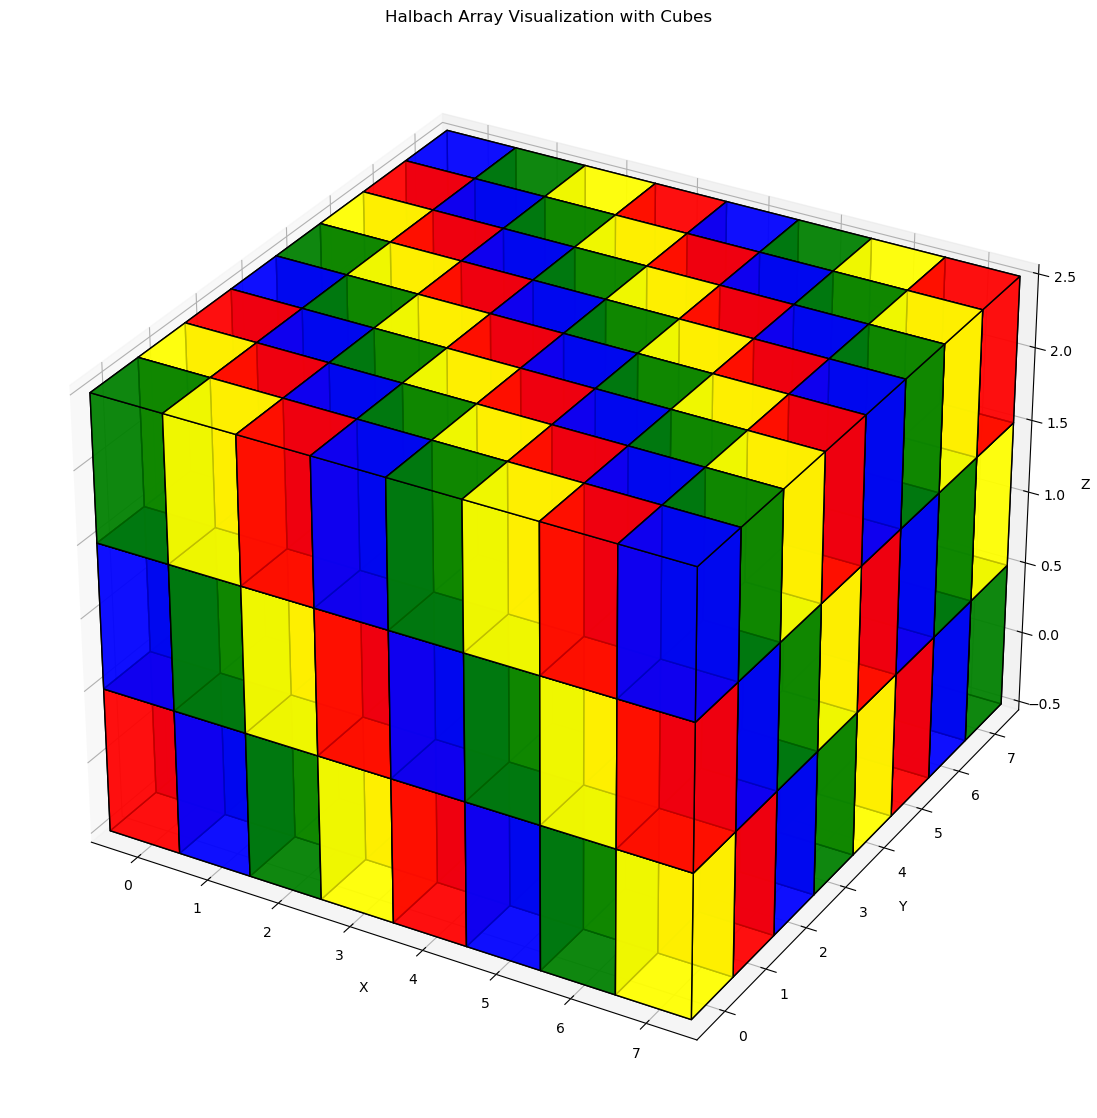

In [5]:
# displaying the original structure
visualize_halbach_array(origin)


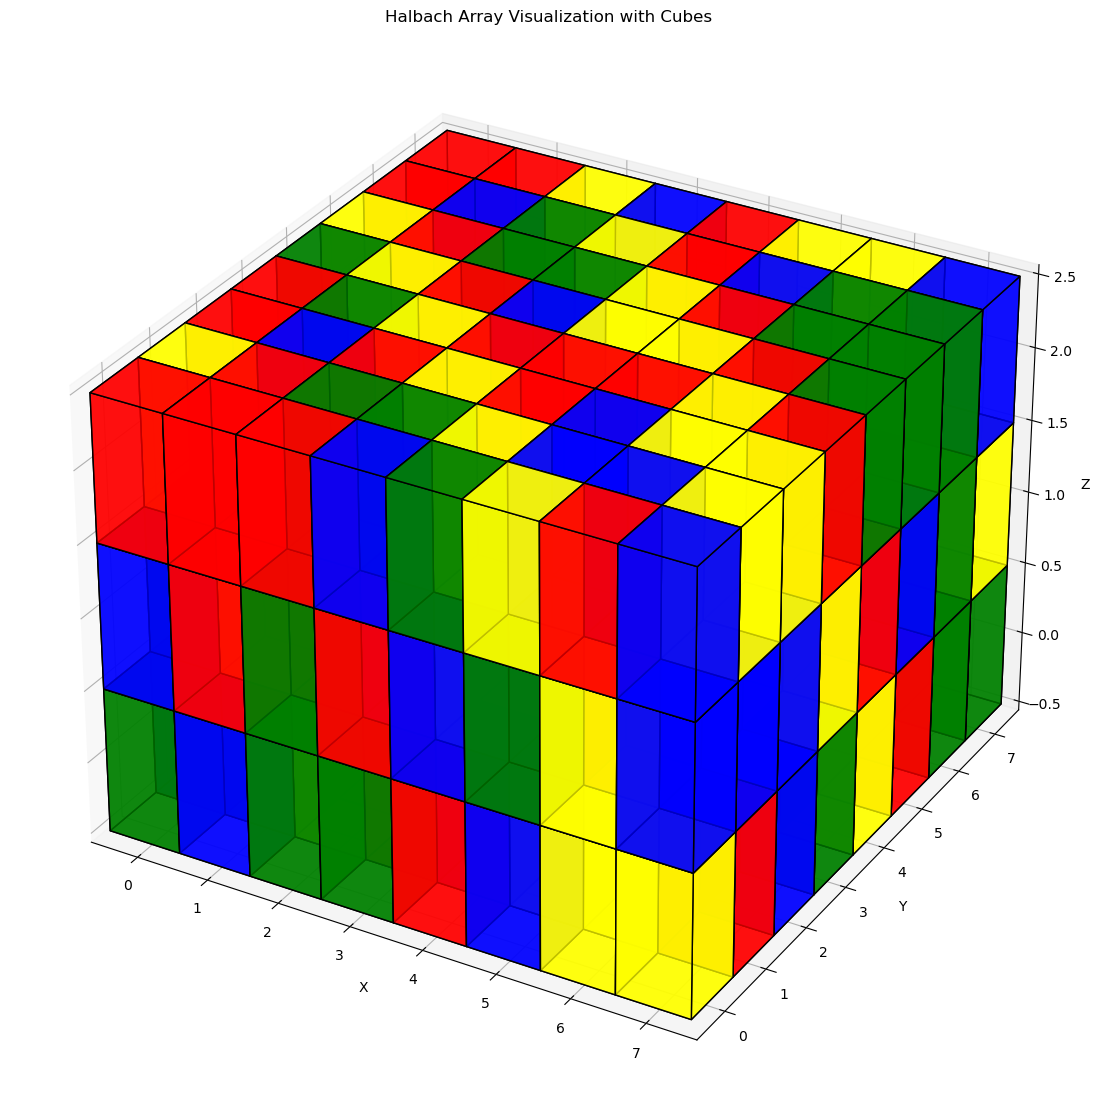

In [6]:
# displaying the end result
visualize_halbach_array(obs)


## Findings


* Upon starting with the basic halbach array configuration, the end structure is slightly distorted. implying that there exists a configuration that has more intense magnetic field strength.
* The resultant structure is not constant meaning when one runs the program again they won't end up with the same configuration as the one they got before. 

## Recommendations

- It is important to note that the illustrations represent only a fraction of the potential permutations and combinations that the structure can form. There are still many configurations that remain unexplored and untested.
- Since the attached files are based on simulations, analysis grounded in real-world implementations would provide more accurate insights.
- Scaling up such a structure shall be material-intensive, making downscaling a logical alternative. At the nanometer scale, particularly below 100 nanometers, quantum effects become apparent. It would be enlightening to investigate how the Halbach array behaves at such a scale.
- To address the material-intensive constraints of the structure, utilizing electric coils arranged in a Halbach array format is a viable option. Additionally, employing light, which possesses a magnetic component that can be organized in a Halbach array configuration, offers another innovative solution.
- *Although the entire structure is based on a dimensional perspective, it is particularly interesting to analyze and study how the various patterns diffuse, change, transform, and shift between configurations.*